In [1]:
from python_gdal import *
from models_keras import *
import time
from keras import backend as K

Using TensorFlow backend.


In [2]:
MAIN_FOLDER = r'E:/HSI/'
IP_DATA_PATH = 'IP/Indian_pines_corrected'
IP_TRAIN_PATH = 'IP/Indian_pines_gt'
PAVIA_DATA_PATH = "Pavia/Pavia"
PAVIA_TRAIN_PATH = "Pavia/Pavia_gt"
PAVIA_U_DATA_PATH = "Pavia/PaviaU"
PAVIA_U_TRAIN_PATH = "Pavia/PaviaU_gt"
SALINAS_DATA_PATH = "Salinas/Salinas"
SALINAS_TRAIN_PATH = 'Salinas/Salinas_gt'
KSC_DATA_PATH = "KSC/KSC"
KSC_TRAIN_PATH = "KSC/KSC_gt"
IEEEHSI_2018_DATA_PATH = "2018IEEEHSI/FullHSIDataset/20170218_UH_CASI_S4_NAD83.pix"
IEEEHSI_2018_TRAIN_PATH = "2018IEEEHSI/GT"

In [3]:
c = [16, 9, 9, 13]
input_shape1 = [(200,), (102,), (103,), (176,)]
input_shape2 = [(200, 1), (102, 1), (103, 1), (176, 1)]
lists2 = [200, 200, 200, 200, 200, 200, 200, 200, 200]
lists1 = [33, 200, 200, 181, 200, 200, 20, 200, 14, 200, 200, 200, 143, 200, 200, 75]
lists3 = [200, 150, 150, 150, 100, 150, 50, 200, 200, 200, 200, 200, 200]
lists = [lists1, lists2, lists2, lists3]
image_shape = [(145, 145), (1096, 715), (610, 340), (512, 614)]
DATA_PATH = [IP_DATA_PATH, PAVIA_DATA_PATH, PAVIA_U_DATA_PATH, KSC_DATA_PATH]
TRAIN_PATH = [IP_TRAIN_PATH, PAVIA_TRAIN_PATH, PAVIA_U_TRAIN_PATH, KSC_TRAIN_PATH]

In [16]:
i = 0
m = 17

# data prep

In [17]:
train_samples_1, train_labels_1 = get_train_sample(data_path=MAIN_FOLDER+DATA_PATH[i],
                                               train_data_path=MAIN_FOLDER+TRAIN_PATH[i],
                                               c=c[i], m=m, lists=lists[i], d=4)

In [18]:
print(train_samples_1.shape)

(2466, 17, 17, 200)


In [55]:
t = train_samples_1[:, 8, 8, :]
t1= np.expand_dims(t, axis=-1)
print(t1.shape)

(2466, 200, 1)


In [19]:
train_samples_2, train_labels_2 = get_train_sample(data_path=MAIN_FOLDER+DATA_PATH[i],
                                               train_data_path=MAIN_FOLDER+TRAIN_PATH[i],
                                               c=c[i], m=1, lists=lists[i], d=3)

In [20]:
print(train_samples_2.shape)

(2466, 200, 1)


In [21]:
train_labels = one_hot_encode(c=c[i], labels=train_labels_1)

In [22]:
print(train_labels_1[:10])
print(train_labels_2[:10])

[12.  4.  4. 10. 14. 14. 14.  8.  8.  8.]
[12.  4.  4. 10. 14. 14. 14.  8.  8.  8.]


# model prep

In [44]:
input_1 = (200, 1)
input_2 = (17, 17, 200)

In [47]:
def combined_1d_2d(input_1, input_2, c, lr):
    inputs_1 = Input(shape=input_1)
    inputs_2 = Input(shape=input_2)
    x_1 = Conv1D(24, 3, padding='same')(inputs_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation='relu')(x_1)
    x_1 = MaxPool1D(2, padding='same')(x_1)

    x_1 = Conv1D(36, 3, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation='relu')(x_1)
    x_1 = MaxPool1D(3, padding='same')(x_1)
    x_1 = Dropout(rate=0.1)(x_1)

    x_1 = Conv1D(48, 3, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation='relu')(x_1)
    x_1 = MaxPool1D(2, padding='same')(x_1)
    x_1= Dropout(rate=0.1)(x_1)

    x_1 = Conv1D(96, 4, padding='same')(x_1)
    x_1 = BatchNormalization()(x_1)
    x_1 = Activation(activation='relu')(x_1)
    x_1 = MaxPool1D(2, padding='same')(x_1)
    x_1 = Dropout(rate=0.1)(x_1)

    x_1 = Flatten()(x_1)

    x_2 = Conv2D(12, (3, 3), padding='same')(inputs_2)
    x_2 = BatchNormalization()(x_2)
    x_2 = Activation(activation='relu')(x_2)
    x_2 = MaxPool2D(pool_size=2, padding='same')(x_2)

    x_2 = Conv2D(24, (3, 3), padding='same')(x_2)
    x_2 = BatchNormalization()(x_2)
    x_2 = Activation(activation='relu')(x_2)
    x_2 = MaxPool2D(pool_size=2, padding='same')(x_2)

    x_2 = Conv2D(48, (3, 3), padding='same')(x_2)
    x_2 = BatchNormalization()(x_2)
    x_2 = Activation(activation='relu')(x_2)
    x_2 = MaxPool2D(pool_size=2, padding='same')(x_2)
    x_2 = Dropout(rate=0.2)(x_2)

    x_2 = Flatten()(x_2)

    combine_layer = concatenate([x_1, x_2], axis=1)

    y = Dense(256, activation='relu')(combine_layer)

    output = Dense(c, activation='softmax')(y)

    model = Model(inputs=[inputs_1, inputs_2], outputs=output)
    model.compile(optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [48]:
combine_model = combined_1d_2d(input_1, input_2, c=16, lr=0.0001)

In [49]:
combine_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 200, 1)       0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 200, 24)      96          input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 200, 24)      96          conv1d_5[0][0]                   
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 200, 24)      0           batch_normalization_8[0][0]      
__________________________________________________________________________________________________
max_poolin

In [57]:
print(train_samples_2.shape)

(2466, 200, 1)


In [58]:
train_samples_2 = np.expand_dims(train_samples_1[:, 8, 8, :], axis=-1)

In [59]:
network = combine_model.fit(x=[train_samples_2, train_samples_1],
                            y = train_labels, epochs=20, verbose=1)

Epoch 1/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.1086 - acc: 0.9688
Epoch 2/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0632 - acc: 0.9878
Epoch 3/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0950 - acc: 0.9708
Epoch 4/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0573 - acc: 0.9886
Epoch 5/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0571 - acc: 0.9866A: 1s - loss
Epoch 6/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0494 - acc: 0.9891
Epoch 7/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0512 - acc: 0.9874
Epoch 8/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.1056 - acc: 0.9639
Epoch 9/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0429 - acc: 0.9915
Epoch 10/20
2466/2466 [==============================] - 7s 3ms/step - loss: 0.0785 - acc: 0.9765
Epoch 11/20
2466/

In [60]:
save_model(combine_model, "cnn_1d_2d_17.h5")

In [63]:
def get_test_predict(model, data_path, train_data_path, c, lists, bsize, norma_methods='z-score', pca=False, m=1, n=3):
    bands_data, is_train, training_labels = get_prep_data(data_path, train_data_path,
                                                          norma_method=norma_methods,
                                                          pca=pca, n=n)
    _, x_test_index, _, y_test = custom_train_index(is_train, training_labels, c=c, lists=lists)
    samples = []
    predicts = []
    if m == 1:
        for i in x_test_index:
            sample = bands_data[i[0], i[1]]
            samples.append(sample)
        samples = np.stack(samples)
        if len(model.input.shape) == 3:
            samples = samples.reshape((samples.shape[0], samples.shape[1], -1))
        predicts = model.predict(samples)

    else:
        n = int((m - 1) / 2)
        x_test_nindex = x_test_index + n
        bands_data = np.pad(bands_data, ((n, n), (n, n), (0, 0)), 'constant', constant_values=0)
        for i, j in enumerate(x_test_nindex):
            k1 = j[0] - n
            k2 = j[0] + n + 1
            k3 = j[1] - n
            k4 = j[1] + n + 1
            block = bands_data[k1:k2, k3:k4]
            samples.append(block)
            if len(samples) == bsize or i == x_test_nindex.shape[0] - 1:
                # print("Batches Predictions...")
                pre = np.stack(samples)
#                 if len(model.input.shape) == 5:
#                     pre = pre.reshape((pre.shape[0], pre.shape[1], pre.shape[2], pre.shape[3], -1))
                pre1 = np.expand_dims(pre[:, n, n, :], axis=-1) 
                predict = model.predict([pre1, pre])
                predicts.append(predict)
                samples = []
        predicts = np.concatenate(predicts)
    print("Batches Predictions Finish!!!")
    OA, KAPPA = print_plot_cm(y_test, predicts)
    return OA, KAPPA

In [64]:
OA, KAPPA = get_test_predict(model=combine_model, data_path=MAIN_FOLDER+DATA_PATH[i],
                             train_data_path=MAIN_FOLDER+TRAIN_PATH[i], c=16,
                             lists=lists[i], bsize=3200, norma_methods='z-score',m=17)

Batches Predictions Finish!!!


In [65]:
print(OA, KAPPA)

0.9614544520107927 0.9546723210077922


# features prep

In [23]:
cnn_1d_path = r"e:/HSI/code/new_model_0/"
cnn_2d_path = r"e:/HSI/code/new_model_2/"

In [25]:
cnn_1d_model = load_model(cnn_1d_path + "cnn_1d_IP.h5")
cnn_2d_model = load_model(cnn_2d_path + "17-cnn_2d_IP.h5")

In [66]:
cnn_1d_feature = K.function([cnn_1d_model.layers[0].input, K.learning_phase()],
                            [cnn_1d_model.layers[-4].output])

In [67]:
cnn_2d_feature = K.function([cnn_2d_model.layers[0].input, K.learning_phase()],
                            [cnn_2d_model.layers[-4].output])

In [80]:
features_1d = cnn_1d_feature([train_samples_2])[0]

In [81]:
features_2d = cnn_2d_feature([train_samples_1])[0]

In [82]:
print(features_1d.shape)
print(features_2d.shape)

(2466, 864)
(2466, 432)


# features concatenate

In [83]:
fusion_layer = np.concatenate([features_1d, features_2d], axis=1)

In [84]:
print(fusion_layer.shape)

(2466, 1296)


In [113]:
inputs = Input(shape=(fusion_layer.shape[-1],))
y = Dense(128, activation='relu')(inputs)
y = Dense(128, activation='relu')(y)
output = Dense(c[0], activation='softmax')(y)

In [114]:
model1 = Model(inputs=inputs, outputs=output)

In [115]:
model1.compile(optimizer=Adam(0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [116]:
network = model1.fit(fusion_layer, train_labels, batch_size=50, epochs=50, verbose=1)

Epoch 1/50
2466/2466 [==============================] - 1s 532us/step - loss: 2.2279 - acc: 0.4270
Epoch 2/50
2466/2466 [==============================] - 0s 80us/step - loss: 1.1876 - acc: 0.7713
Epoch 3/50
2466/2466 [==============================] - 0s 80us/step - loss: 0.6754 - acc: 0.8865
Epoch 4/50
2466/2466 [==============================] - 0s 80us/step - loss: 0.4230 - acc: 0.9343
Epoch 5/50
2466/2466 [==============================] - 0s 80us/step - loss: 0.2869 - acc: 0.9590
Epoch 6/50
2466/2466 [==============================] - 0s 78us/step - loss: 0.2047 - acc: 0.9704
Epoch 7/50
2466/2466 [==============================] - 0s 80us/step - loss: 0.1517 - acc: 0.9797
Epoch 8/50
2466/2466 [==============================] - 0s 80us/step - loss: 0.1178 - acc: 0.9895
Epoch 9/50
2466/2466 [==============================] - 0s 82us/step - loss: 0.0927 - acc: 0.9943
Epoch 10/50
2466/2466 [==============================] - 0s 81us/step - loss: 0.0760 - acc: 0.9955
Epoch 11/50
2466/2

Overall Accuracy:100.0000%
Kappa:  1.0
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        33
           2     1.0000    1.0000    1.0000       200
           3     1.0000    1.0000    1.0000       200
           4     1.0000    1.0000    1.0000       181
           5     1.0000    1.0000    1.0000       200
           6     1.0000    1.0000    1.0000       200
           7     1.0000    1.0000    1.0000        20
           8     1.0000    1.0000    1.0000       200
           9     1.0000    1.0000    1.0000        14
          10     1.0000    1.0000    1.0000       200
          11     1.0000    1.0000    1.0000       200
          12     1.0000    1.0000    1.0000       200
          13     1.0000    1.0000    1.0000       143
          14     1.0000    1.0000    1.0000       200
          15     1.0000    1.0000    1.0000       200
          16     1.0000    1.0000    1.0000        75

   micro avg     1.0000    1.0000    1.00

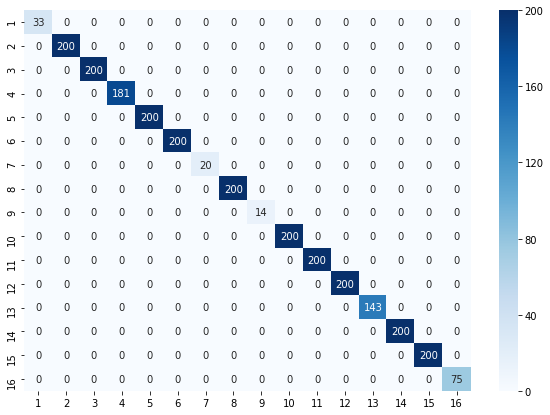

In [60]:
predic = model.predict(fusion_layer)
print_plot_cm(train_labels, predic)

In [90]:
bands_data, is_train, training_labels = get_prep_data(data_path=MAIN_FOLDER+DATA_PATH[i], 
                                                      train_data_path=MAIN_FOLDER+TRAIN_PATH[i])

In [91]:
_, x_test_index, _, y_test = custom_train_index(is_train, training_labels, c=c[i], 
                                                lists=lists[i])

In [92]:
samples = []
for j in x_test_index:
    sample = bands_data[j[0], j[1]]
    samples.append(sample)
samples = np.stack(samples)
samples = samples.reshape((samples.shape[0], samples.shape[1], -1))

In [93]:
print(samples.shape)

(7783, 200, 1)


In [94]:
featurs_1 = cnn_1d_feature([samples])[0]

In [95]:
print(featurs_1.shape)

(7783, 864)


In [96]:
samples_1 = []
features = []
n = int((m - 1) / 2)
x_test_nindex = x_test_index + n
bands_data = np.pad(bands_data, ((n, n), (n, n), (0, 0)), 'constant', constant_values=0)
for i, j in enumerate(x_test_nindex):
    k1 = j[0] - n
    k2 = j[0] + n + 1
    k3 = j[1] - n
    k4 = j[1] + n + 1
    block = bands_data[k1:k2, k3:k4]
    samples_1.append(block)
    if len(samples_1) == 3200 or i == x_test_nindex.shape[0] - 1:
        print("Batches Features...")
        pre = np.stack(samples_1)
        feature = cnn_2d_feature([pre])[0]
        features.append(feature)
        samples_1 = []
features = np.concatenate(features)

Batches Features...
Batches Features...
Batches Features...


In [97]:
print(features.shape)

(7783, 432)


In [98]:
fea = np.concatenate([featurs_1, features], axis=1)
print(fea.shape)

(7783, 1296)


In [99]:
pred = model1.predict(fea)

In [100]:
print_plot_cm(y_test, pred)

(0.9838108698445329, 0.9808960761057184)

In [127]:
bands_data_dict = sio.loadmat(MAIN_FOLDER+DATA_PATH[0])
bands_data_1 = bands_data_dict[list(bands_data_dict.keys())[-1]]
bands_data_1 = norma_data(bands_data_1)

In [128]:
print(MAIN_FOLDER+DATA_PATH[0])

E:/HSI/IP/Indian_pines_corrected


In [129]:
pre = bands_data_1.reshape((bands_data_1.shape[0]*bands_data_1.shape[1], bands_data_1.shape[2], -1))

In [130]:
print(pre.shape)

(21025, 200, 1)


In [131]:
f1 = cnn_1d_feature([pre])[0]

In [132]:
print(f1.shape)

(21025, 864)


In [133]:
print(bands_data_1.shape)

(145, 145, 200)


In [134]:
n = int((m - 1) / 2)
bands_data_1 = np.pad(bands_data_1, ((n, n), (n, n), (0, 0)), 'constant', constant_values=0)
cols = bands_data_1.shape[1]-2*n
rows = bands_data_1.shape[0]-2*n
result1 = []
f2 = []
for g in range(0, rows, 1):
    for h in range(0, cols, 1):
        data = bands_data_1[g: g + m, h: h + m, :]
        result1.append(data)
        if len(result1) == 3200 or g == int(rows-1):
            print("Batches Features...")
            pre1 = np.stack(result1)
            fe = cnn_2d_feature([pre1])[0]
            f2.append(fe)
            result1 = []
f2 = np.concatenate(f2)

Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...
Batches Features...


In [135]:
print(f2.shape)

(21025, 432)


In [136]:
f3 = np.concatenate([f1, f2], axis=1)

In [137]:
p = model1.predict(f3)

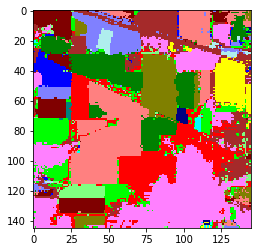

(0.060975029726516056, 0.16661117717003568, 0.09341260404280619)

In [138]:
write_whole_image_classification_result(p, shape=(145, 145))

write_whole_image_predicts_prob(p, shape=(145, 145))